<h1 style = "text-align:center;">Forecasting the Mortality Rate of COVID-19 in South Korea</h1>

<br>**OVERVIEW**: In this project, a COVID-19 dataset for South Korea will be explored with the primary mission of constructing a machine learning model that can accurately forecast the mortality rate based on patient infection case, age and province.

<br>

<h3 style="text-align:center;">Business Understanding</h3><br>

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;From a business perspective, building a machine learning model to forecast the mortality rate of COVID-19 patients living in South Korea can be framed as addressing the susceptibility factors for the virus. Determining the main causes of infection, patients who are most vulnerable, and high alert provinces are therefore pertinent to this project. In other words, what is the total number of deceased COVID-19 patients for each age group and province in South Korea given the cause of infection? Can the COVID-19 mortality rate be accurately forecasted based on these variables? If so, what can be gleaned from the results? These research questions form the basis of this anaysis and project as a whole.
<br><br><br>

<h3 style="text-align:center;">Data Understanding</h3><br>

The purpose of this section is to provide a solid foundation for understanding the project data. Some first steps towards this initiative are:<br>

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;a) Viewing the dataset structure
<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;b) Isolating the features aligning with project requirements
<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;c) Acknowledging the different types of data present
<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;d) Identifying dummy variables (eg. index variables such as id) and unnecessary variables (i.e. do not influence the models) 
<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;e) Checking for problematic variables (lots of missing entries or duplicates)


<br><center>**Data Description** (from documentation in README)</center><br>
1) Case Data
   - Case: Data of COVID-19 infection cases in South Korea
<br>
<br>
  
2) Patient Data
    - PatientInfo: Epidemiological data of COVID-19 patients in South Korea
    - PatientRoute: Route data of COVID-19 patients in South Korea (currently unavailable)
<br>
<br>
      
3) Time Series Data
    - Time: Time series data of COVID-19 status in South Korea
    - TimeAge: Time series data of COVID-19 status in terms of the age in South Korea
    - TimeGender: Time series data of COVID-19 status in terms of gender in South Korea
    - TimeProvince: Time series data of COVID-19 status in terms of the Province in South Korea
<br>
<br>
      
4) Additional Data
    - Region: Location and statistical data of the regions in South Korea
    - Weather: Data of the weather in the regions of South Korea
    - SearchTrend: Trend data of the keywords searched in NAVER which is one of the largest portals in South Korea
    - SeoulFloating: Data of floating population in Seoul, South Korea (from SK Telecom Big Data Hub)
    - Policy: Data of the government policy for COVID-19 in South Korea
<br>


<br><center>**Isolate Project Data**<center><br><br>

Recall this project aims to build a time series forecasting model based on the patient infection case, age and province. With that in mind,  
- All additional datasets can be safely ignored aside from the Region dataset
<br>
<br>
- Province information can be found in the Region dataset, but it has no time attribute. The PatientInfo dataset also has province data, but there are no desirable features in Region to justify merging the two.
<br>
<br>
- The TimeGender dataset is irrelevant as the forecasting models will not be trained on patient gender data
<br>
<br>
- The Case dataset carries infection case information, but lacks a date attribute. Furthermore, infection case data already exists in PatientInfo and combining these datasets does not gain any useful features.
<br>
<br>
- The Time dataset is a generalization of the TimeAge and TimeProvince datasets; no age or province data is tracked 
<br>
<br>
- Lastly, this analysis is not concerned with the route data inside the PatientRoute dataset
<br>


<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Remaining are the PatientInfo, TimeAge and TimeProvince datasets. To create the final time series datasets, PatientInfo will be merged with TimeAge and TimeProvince separately. Since PatientInfo contains both age and province attributes, the merged time series dataset will consist of patient infection case, age and province data. 
<br>

<br><center>**Library Setup and Loading the Data**<center><br>

In [1428]:
# libraries for creating dataframes and graphical analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# functionality for train-test splitting and computing error metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error

# functionality for time series decomposition, modeling, testing stationarity, plotting ACFs and PACFs
from statsmodels.tsa.seasonal import STL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA

# import functionality for displaying multiple dataframes
from IPython.display import display, HTML

# import functionality for silencing error messages
import warnings

In [1430]:
# load datasets
patient_data = pd.read_csv("data/PatientInfo.csv")
time_age_data = pd.read_csv("data/TimeAge.csv")
time_prov_data = pd.read_csv("data/TimeProvince.csv")

<br><center>**Examining the Data**<center><br>

In [1433]:
patient_data.head()

,patient_id,sex,age,country,province,city,infection_case,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state
0,1000000001,male,50s,Korea,Seoul,Gangseo-gu,overseas inflow,NaN,75,2020-01-22,2020-01-23,2020-02-05,NaN,released
1,1000000002,male,30s,Korea,Seoul,Jungnang-gu,overseas inflow,NaN,31,NaN,2020-01-30,2020-03-02,NaN,released
2,1000000003,male,50s,Korea,Seoul,Jongno-gu,contact with patient,2002000001,17,NaN,2020-01-30,2020-02-19,NaN,released
3,1000000004,male,20s,Korea,Seoul,Mapo-gu,overseas inflow,NaN,9,2020-01-26,2020-01-30,2020-02-15,NaN,released
4,1000000005,female,20s,Korea,Seoul,Seongbuk-gu,contact with patient,1000000002,2,NaN,2020-01-31,2020-02-24,NaN,released


For patient data: 
- dummy variable is 'patient_id'
- unnecessary variables are 'sex', 'country', 'city', 'infected_by', 'contact_number', 'symptom_onset_date', 'confirmed_date', 'released_date', 'deceased_date' and 'state'
- problematic variables are 'infected_by', 'symptom_onset_date' and 'deceased_date'
<br><br>

In [1436]:
patient_data['infection_case'].value_counts().iloc[[0]] # retrieve most frequent infection case

infection_case
contact with patient    1610
Name: count, dtype: int64

<br>**Observation A:** the code cell above finds the most frequent infection case, which turns out to be "contact with patient". Naturally, this is a prime candidate for the target infection case.<br><br>

In [1439]:
time_age_data.head()

,date,time,age,confirmed,deceased
0,2020-03-02,0,0s,32,0
1,2020-03-02,0,10s,169,0
2,2020-03-02,0,20s,1235,0
3,2020-03-02,0,30s,506,1
4,2020-03-02,0,40s,633,1


For time age data: 
- no dummy variables
- unnecessary variables are 'time' and 'confirmed'
- no problematic variables
<br><br>

In [1442]:
time_prov_data.head()

,date,time,province,confirmed,released,deceased
0,2020-01-20,16,Seoul,0,0,0
1,2020-01-20,16,Busan,0,0,0
2,2020-01-20,16,Daegu,0,0,0
3,2020-01-20,16,Incheon,1,0,0
4,2020-01-20,16,Gwangju,0,0,0


For time province data: 
- no dummy variables
- unnecessary variables are 'time' and 'confirmed'
- no problematic variables
<br><br>

<h3 style="text-align:center;">Data Cleaning</h3><br>

To begin, the datasets must be cleaned and refined before they can be used for modeling. This process involves: 
- Feature selection
- Eliminating duplicates
- Handling missing data
- Resolving structural errors
- Filtering outliers
- Validating data

1. Select important features for time series analysis

In [1447]:
patient_data = patient_data[['age', 'province', 'infection_case']]
time_age_data = time_age_data[['date', 'age', 'deceased']]
time_prov_data = time_prov_data[['date', 'province', 'deceased']]

2. Remove any duplicate rows in datasets

In [1450]:
patient_data = patient_data.drop_duplicates()
time_age_data = time_age_data.drop_duplicates()
time_prov_data = time_prov_data.drop_duplicates()

3. Drop entries with missing values in patient and time province data (NOTE: no missing values in time age data)

In [1453]:
patient_data = patient_data.dropna()
time_prov_data = time_prov_data.dropna()

# check for missing values in time_age_data
time_age_data.isnull().sum()

date        0
age         0
deceased    0
dtype: int64

4. Merge patient info with time age and province data separately to obtain desired time series datasets

In [1456]:
# merge patient_data and time_age_data on related 'age' attribute using an outer join
patient_time_age_data = pd.merge(left = patient_data[['age', 'infection_case']], right = time_age_data, on = 'age', how = 'outer')

# Merge patient_data and time_province_data on related 'province' attribute using an outer join
patient_time_prov_data = pd.merge(left = patient_data[['province', 'infection_case']], right = time_prov_data, on = 'province', how = 'outer')

5. Ensure no missing values or duplicates exist in merged data

In [1459]:
# drop rows in patient time age and province data with missing values
patient_time_age_data = patient_time_age_data.dropna()
patient_time_prov_data = patient_time_prov_data.dropna()

# drop duplicate rows in patient time age and province data
patient_time_age_data = patient_time_age_data.drop_duplicates()
patient_time_prov_data = patient_time_prov_data.drop_duplicates()

6. Resolve any structural errors in patient time age and province datasets (NOTE: 'date' attributes will be converted to datetime dtype later)

In [1462]:
patient_time_age_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17545 entries, 0 to 56628
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             17545 non-null  object 
 1   infection_case  17545 non-null  object 
 2   date            17545 non-null  object 
 3   deceased        17545 non-null  float64
dtypes: float64(1), object(3)
memory usage: 685.4+ KB


In [1464]:
# resolve structure errors in patient_time_age_data
patient_time_age_data['age'] = patient_time_age_data['age'].astype("string")
patient_time_age_data['infection_case'] = patient_time_age_data['infection_case'].astype("string")
patient_time_age_data['deceased'] = patient_time_age_data['deceased'].astype(int)

In [1467]:
patient_time_prov_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17767 entries, 0 to 77587
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   province        17767 non-null  object
 1   infection_case  17767 non-null  object
 2   date            17767 non-null  object
 3   deceased        17767 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 694.0+ KB


In [1469]:
# resolve structure errors in patient_time_prov_data
patient_time_prov_data['province'] = patient_time_prov_data['province'].astype("string")
patient_time_prov_data['infection_case'] = patient_time_prov_data['infection_case'].astype("string")

<br>

7. a) Choose target ages and provinces as well as an infection case to analyze

   b) Determine total number of days for which age and province data are recorded respectively

   c) Find start and end dates for age as well as province data collection


In [1472]:
# target ages include young to middle-age adults and elderly (NOTE: 30s = ages 30-40)
target_ages = ["30s", "50s", "80s"] 

# target provinces chosen based on population density  
target_provs = ["Seoul", "Gyeongsangbuk-do", "Gangwon-do"]

# choose predominant infection case as target
target_case = "contact with patient"


# total number of days age and province data were recorded from start to end dates
age_record_days = 121
prov_record_days = 163

# start dates for collecting age and province data respectively 
age_start_date = '2020-03-02'
prov_start_date = '2020-01-20'

# last date where age and province data is collected
end_date = '2020-06-30'

8. a) Filter patient time age and province data using target variables

   b) Trim filtered data based on associated number of recording days 

   c) Convert dtypes of 'date' attributes in trimmed data to datetime

   d) Sort data by corresponding start and end collection dates, then set datetime 'date' attributes as indexes

In [1475]:
# create lists to store patient data for target ages and provinces respectively
age_data = []
prov_data = []

# organize and collect patient age data
for age in target_ages:
    # filter patient time age data using target ages and infection case
    data = patient_time_age_data[(patient_time_age_data['age'] == age) & (patient_time_age_data['infection_case'] == target_case)]
    
    data = data[['date', 'deceased']][:age_record_days] # trim filered age data based on age_record_days
    data['date'] = pd.to_datetime(data['date']) # convert 'date' attribute of trimmed age data to datetime 

    # store age data sorted by age start and end collection dates with datetime attribute 'date' set as index
    age_data.append(data.set_index(pd.date_range(age_start_date, end_date)).drop('date', axis = 1))


# organize and collect patient province data
for prov in target_provs:
    data = patient_time_prov_data[(patient_time_prov_data['province'] == prov) & (patient_time_prov_data['infection_case'] == target_case)]
    data = data[['date', 'deceased']][:prov_record_days] 
    data['date'] = pd.to_datetime(data['date']) 

    prov_data.append(data.set_index(pd.date_range(prov_start_date, end_date)).drop('date', axis = 1))
    

9. Outlier analysis

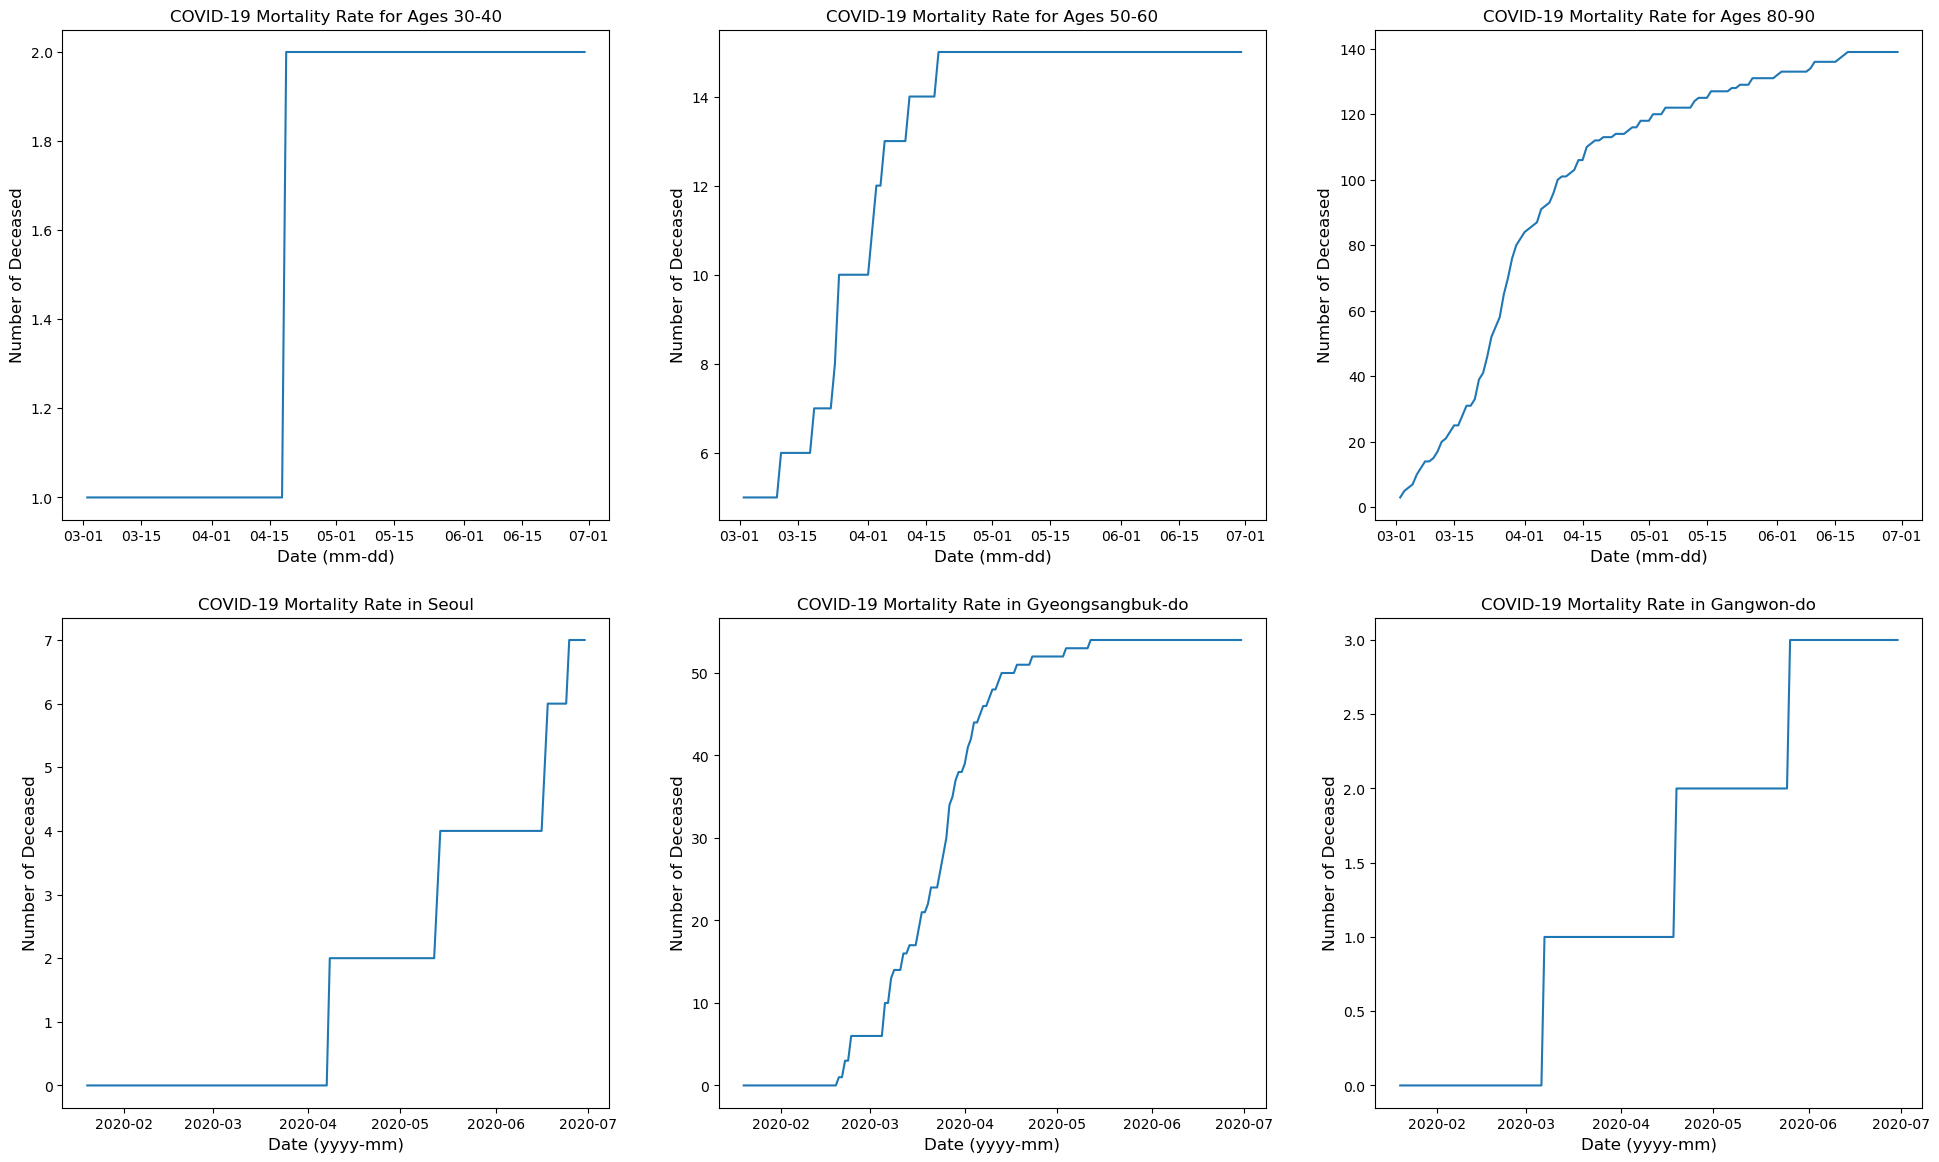

In [1478]:
# create subplots for graphing mortality rates of age and province data
fig, axs = plt.subplots(nrows = 2, ncols = 3, figsize = (24, 14))

# remove year from xtick labels in age graphs for better readability
xtick_labels = ['03-01', '03-15', '04-01', '04-15', '05-01', '05-15', '06-01', '06-15', '07-01']


# plot age 30s data
axs[0, 0].plot(age_data[0]) 
axs[0, 0].set_title("COVID-19 Mortality Rate for Ages 30-40", fontsize = 12)
axs[0, 0].set_xticks(axs[0, 0].get_xticks(), labels = xtick_labels)
axs[0, 0].set_xlabel("Date (mm-dd)", fontsize = 12)
axs[0, 0].set_ylabel("Number of Deceased", fontsize = 12)

# plot age 50s data
axs[0, 1].plot(age_data[1]) 
axs[0, 1].set_title("COVID-19 Mortality Rate for Ages 50-60", fontsize = 12)
axs[0, 1].set_xticks(axs[0, 1].get_xticks(), labels = xtick_labels)
axs[0, 1].set_xlabel("Date (mm-dd)", fontsize = 12)
axs[0, 1].set_ylabel("Number of Deceased", fontsize = 12)

# plot age 80s data
axs[0, 2].plot(age_data[2]) 
axs[0, 2].set_title("COVID-19 Mortality Rate for Ages 80-90", fontsize = 12)
axs[0, 2].set_xticks(axs[0, 2].get_xticks(), labels = xtick_labels)
axs[0, 2].set_xlabel("Date (mm-dd)", fontsize = 12)
axs[0, 2].set_ylabel("Number of Deceased", fontsize = 12)

# plot Seoul data
axs[1, 0].plot(prov_data[0]) 
axs[1, 0].set_title("COVID-19 Mortality Rate in Seoul", fontsize = 12)
axs[1, 0].set_xlabel("Date (yyyy-mm)", fontsize = 12)
axs[1, 0].set_ylabel("Number of Deceased", fontsize = 12)

# plot Gyeongsangbuk-do data
axs[1, 1].plot(prov_data[1]) 
axs[1, 1].set_title("COVID-19 Mortality Rate in Gyeongsangbuk-do", fontsize = 12)
axs[1, 1].set_xlabel("Date (yyyy-mm)", fontsize = 12)
axs[1, 1].set_ylabel("Number of Deceased", fontsize = 12)

# plot Gangwon-do data
axs[1, 2].plot(prov_data[2]) 
axs[1, 2].set_title("COVID-19 Mortality Rate in Gangwon-do", fontsize = 12)
axs[1, 2].set_xlabel("Date (yyyy-mm)", fontsize = 12)
axs[1, 2].set_ylabel("Number of Deceased", fontsize = 12)


# save figure to "images" folder
fig.savefig('images/COVID-19 Mortality Rates for Age and Province.png')

# display subplots
plt.show()

**Observation B:** it is clear by inspection that there are no outliers in the COVID-19 mortality rate for any target age group or province
<br><br>

<h3 style="text-align:center;">Modeling</h3><br>

Now that the age and province datasets are properly formatted, it is time to consider some forecasting models. The goals for this phase are: 
* Performing time series decomposition on the data
* Determining stationarity of the data residues
* Selecting and building multiple forecasting models

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;This analysis selects the autoregressive AR(p) as well as autoregressive moving average ARMA(p, q) forecasting models, where parameters p, q represent orders in the autoregressive and moving average processes respectively. The AR model is chosen as a baseline to compare with the optimal ARMA model. For the best results, these models require the decomposition of age and province data such that their remaining residues are stationary. To achieve this, STL decomposition will be used to extract seasons and trends from the data.

In [1483]:
# lists for storing STL models of decomposed age and province data
age_results = []
prov_results = []

# create, fit and store STL models for age and province data
for i in range(3):
    stl_age = STL(age_data[i])
    age_results.append(stl_age.fit())

    stl_prov = STL(prov_data[i])
    prov_results.append(stl_prov.fit())
    

1. Calculate and plot seasons + trends. 

The STL models built above are additive, meaning their original training data can be reconstructed by summing seasonal components and trends of the resulting data. 

In [1487]:
# lists to store seasons + trends for age and province data
age_season_and_trends = []
prov_season_and_trends = []

# collect seasons + trends 
for i in range(3):
    age_season_and_trends.append(age_results[i].seasonal + age_results[i].trend)
    prov_season_and_trends.append(prov_results[i].seasonal + prov_results[i].trend)


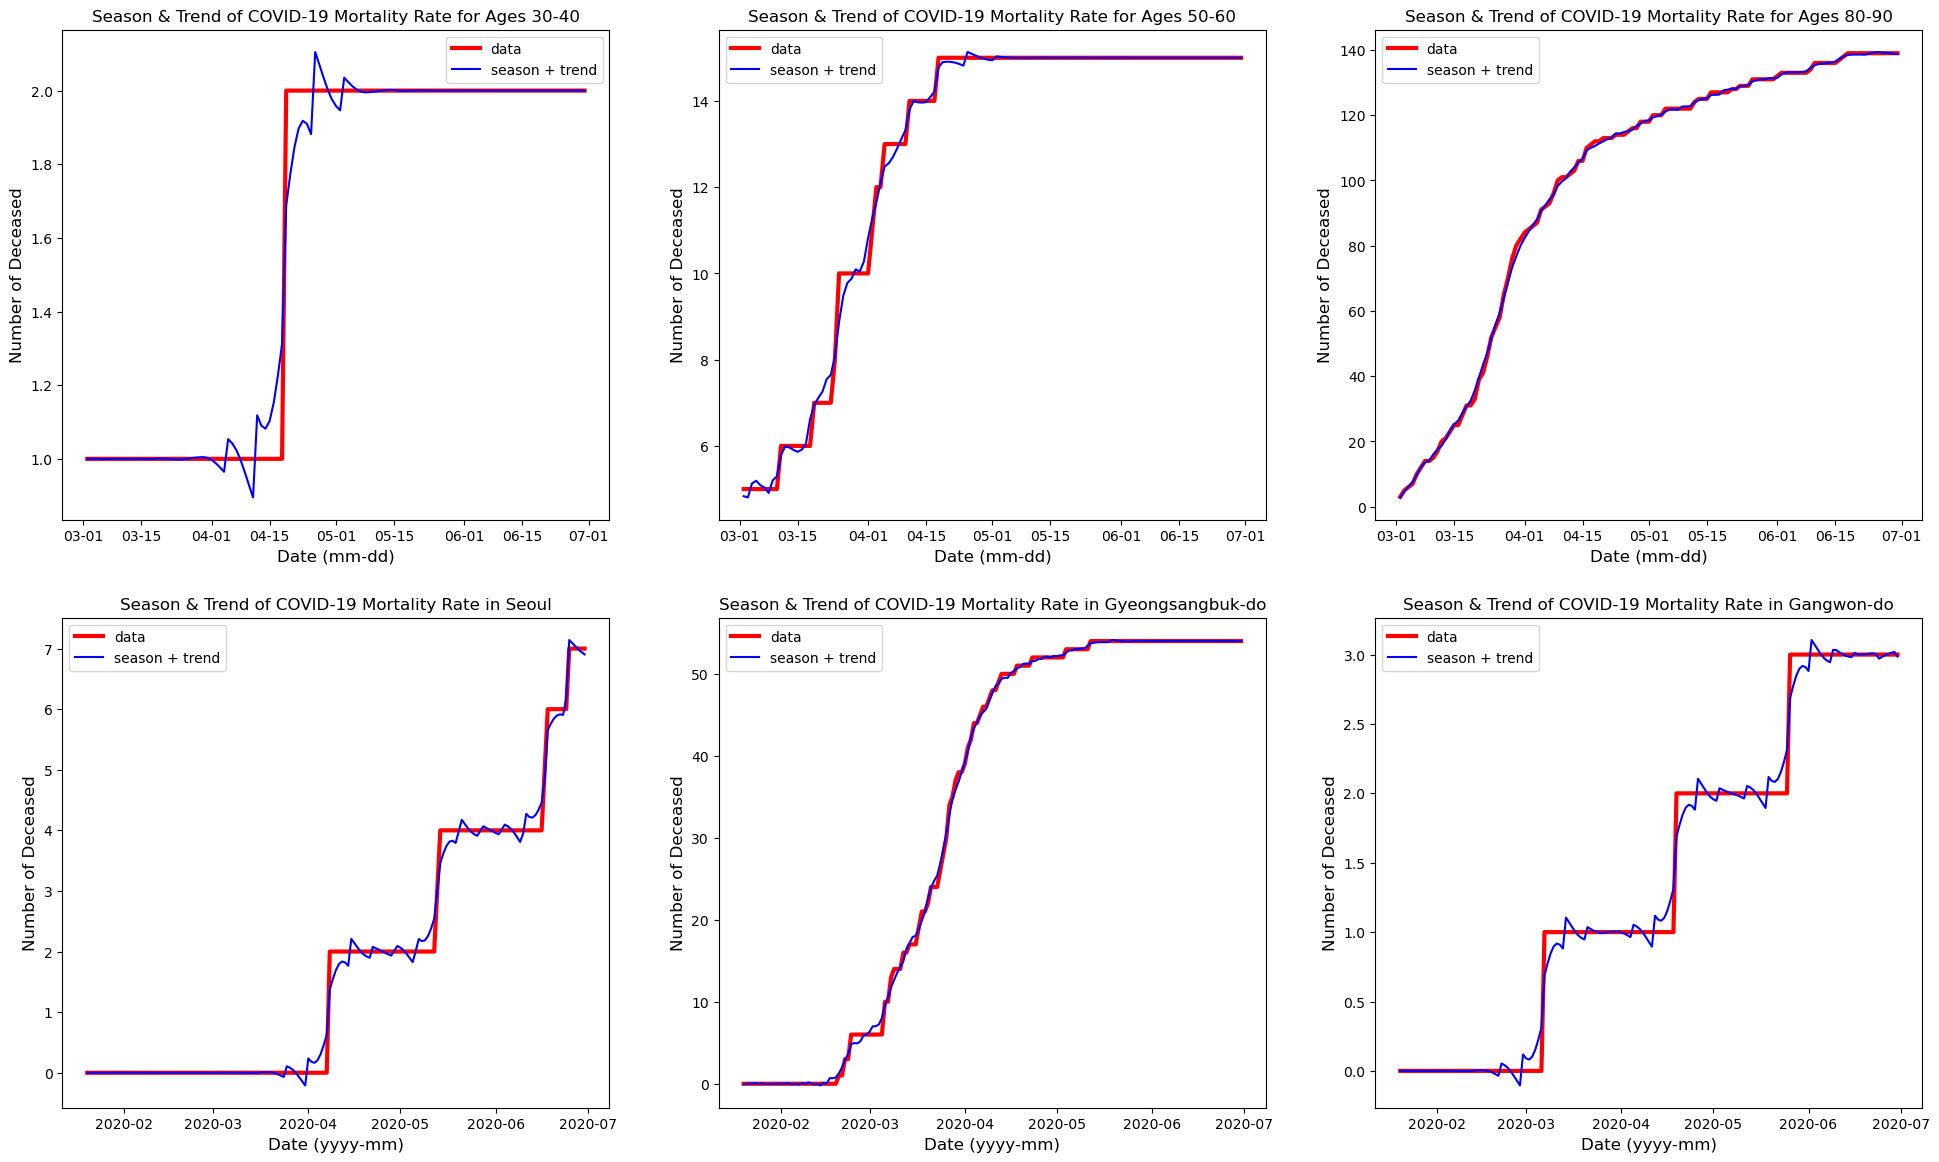

In [1489]:
# create subplot for graphing seasons + trends of age and province data 
fig, axs = plt.subplots(nrows = 2, ncols = 3, figsize = (24, 14))

xtick_labels = ['03-01', '03-15', '04-01', '04-15', '05-01', '05-15', '06-01', '06-15', '07-01']


# plot season + trend for age 30s
axs[0, 0].plot(age_data[0], label = 'data', color = 'red', linewidth = 3) 
axs[0, 0].plot(age_season_and_trends[0], label = 'season + trend', color = 'blue')
axs[0, 0].set_title("Season & Trend of COVID-19 Mortality Rate for Ages 30-40", fontsize = 12)
axs[0, 0].legend()
axs[0, 0].set_xticks(axs[0, 0].get_xticks(), labels = xtick_labels)
axs[0, 0].set_xlabel("Date (mm-dd)", fontsize = 12)
axs[0, 0].set_ylabel("Number of Deceased", fontsize = 12)

# plot season + trend for age 50s
axs[0, 1].plot(age_data[1], label = 'data', color = 'red', linewidth = 3) 
axs[0, 1].plot(age_season_and_trends[1], label = 'season + trend', color = 'blue')
axs[0, 1].set_title("Season & Trend of COVID-19 Mortality Rate for Ages 50-60", fontsize = 12)
axs[0, 1].legend()
axs[0, 1].set_xticks(axs[0, 1].get_xticks(), labels = xtick_labels)
axs[0, 1].set_xlabel("Date (mm-dd)", fontsize = 12)
axs[0, 1].set_ylabel("Number of Deceased", fontsize = 12)

# plot season + trend for age 80s
axs[0, 2].plot(age_data[2], label = 'data', color = 'red', linewidth = 3) 
axs[0, 2].plot(age_season_and_trends[2], label = 'season + trend', color = 'blue')
axs[0, 2].set_title("Season & Trend of COVID-19 Mortality Rate for Ages 80-90", fontsize = 12)
axs[0, 2].legend()
axs[0, 2].set_xticks(axs[0, 2].get_xticks(), labels = xtick_labels)
axs[0, 2].set_xlabel("Date (mm-dd)", fontsize = 12)
axs[0, 2].set_ylabel("Number of Deceased", fontsize = 12)

# plot season + trend for Seoul
axs[1, 0].plot(prov_data[0], label = 'data', color = 'red', linewidth = 3) 
axs[1, 0].plot(prov_season_and_trends[0], label = 'season + trend', color = 'blue')
axs[1, 0].set_title("Season & Trend of COVID-19 Mortality Rate in Seoul", fontsize = 12)
axs[1, 0].legend()
axs[1, 0].set_xlabel("Date (yyyy-mm)", fontsize = 12)
axs[1, 0].set_ylabel("Number of Deceased", fontsize = 12)

# plot season + trend for Gyeongsangbuk-do
axs[1, 1].plot(prov_data[1], label = 'data', color = 'red', linewidth = 3) 
axs[1, 1].plot(prov_season_and_trends[1], label = 'season + trend', color = 'blue')
axs[1, 1].set_title("Season & Trend of COVID-19 Mortality Rate in Gyeongsangbuk-do", fontsize = 12)
axs[1, 1].legend()
axs[1, 1].set_xlabel("Date (yyyy-mm)", fontsize = 12)
axs[1, 1].set_ylabel("Number of Deceased", fontsize = 12)

# plot season + trend for Gangwon-do
axs[1, 2].plot(prov_data[2], label = 'data', color = 'red', linewidth = 3) 
axs[1, 2].plot(prov_season_and_trends[2], label = 'season + trend', color = 'blue')
axs[1, 2].set_title("Season & Trend of COVID-19 Mortality Rate in Gangwon-do", fontsize = 12)
axs[1, 2].legend()
axs[1, 2].set_xlabel("Date (yyyy-mm)", fontsize = 12)
axs[1, 2].set_ylabel("Number of Deceased", fontsize = 12)


fig.savefig('images/Seasons & Trends of COVID-19 Mortality Rate for Age and Province.png')

plt.show()

2. Graph ACFs of residues to determine stationarity and parameters q

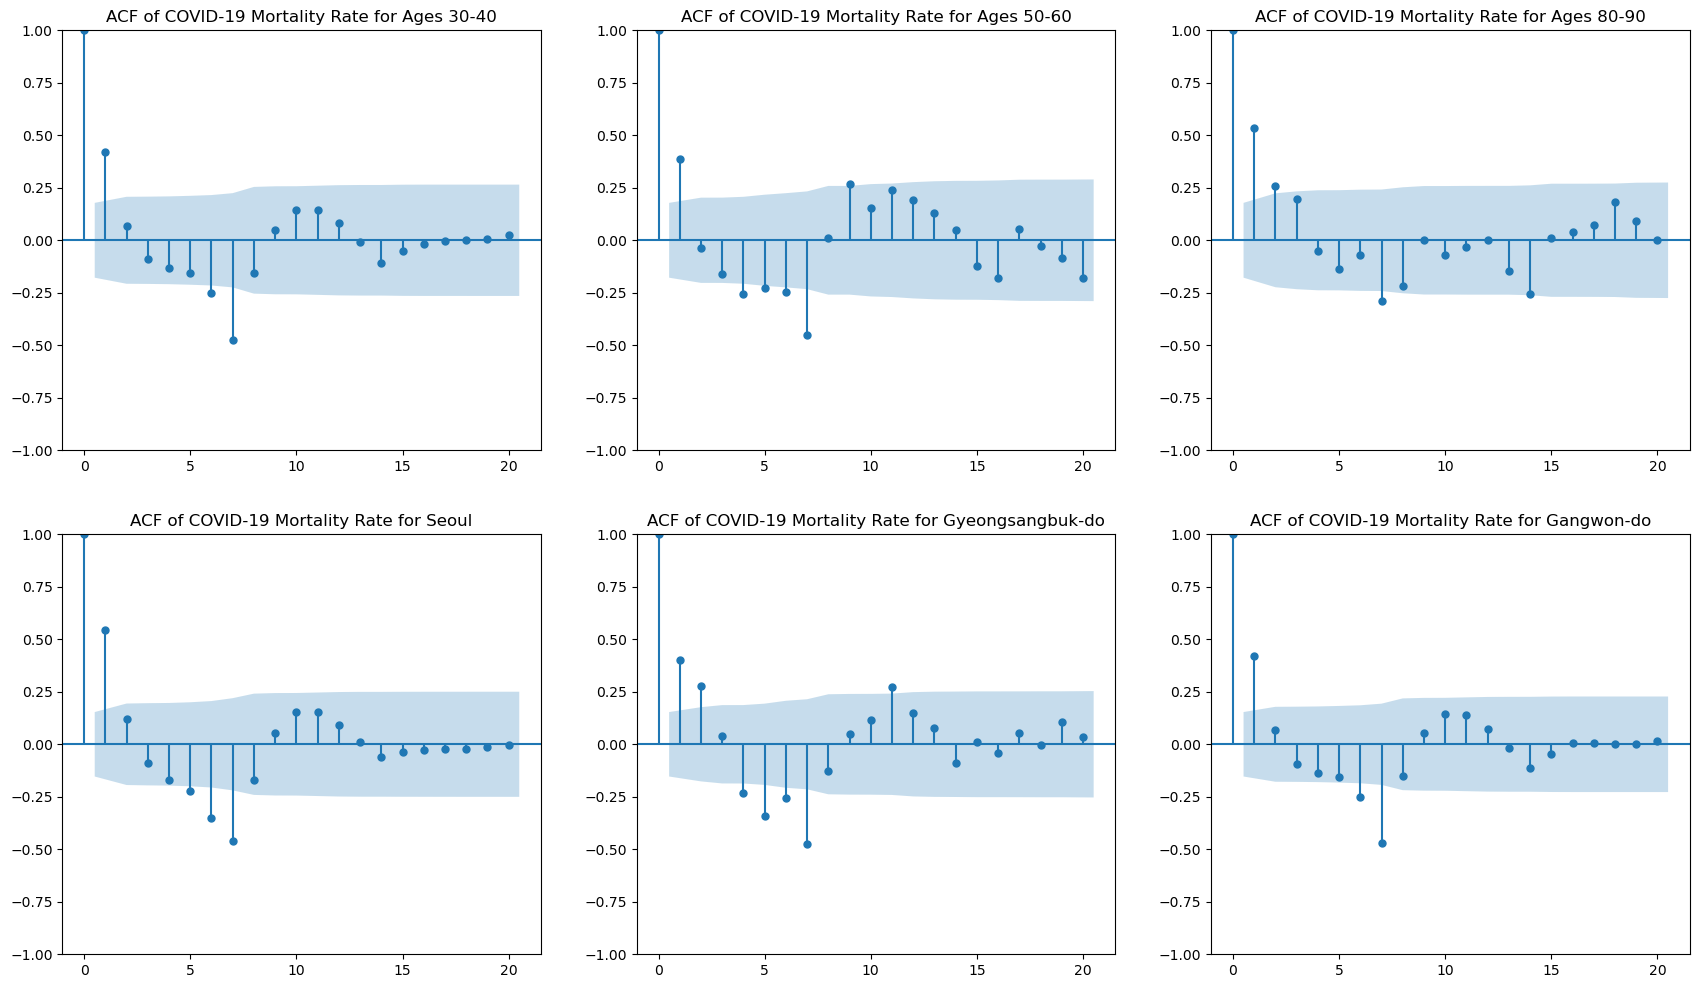

In [1492]:
# create subplot for graphing ACFs of age and province residues
fig, axs = plt.subplots(nrows = 2, ncols = 3, figsize = (21, 12))


# plot ACF of residue for age 30s
plot_acf(age_results[0].resid, lags = 20, ax = axs[0, 0])
axs[0, 0].set_title("ACF of COVID-19 Mortality Rate for Ages 30-40", fontsize = 12)

# plot ACF of residue for age 50s
plot_acf(age_results[1].resid, lags = 20, ax = axs[0, 1])
axs[0, 1].set_title("ACF of COVID-19 Mortality Rate for Ages 50-60", fontsize = 12)

# plot ACF of residue for age 80s
plot_acf(age_results[2].resid, lags = 20, ax = axs[0, 2])
axs[0, 2].set_title("ACF of COVID-19 Mortality Rate for Ages 80-90", fontsize = 12)

# plot ACF of residue for Seoul
plot_acf(prov_results[0].resid, lags = 20, ax = axs[1, 0])
axs[1, 0].set_title("ACF of COVID-19 Mortality Rate for Seoul", fontsize = 12)

# plot ACF of residue for Gyeongsangbuk-do 
plot_acf(prov_results[1].resid, lags = 20, ax = axs[1, 1])
axs[1, 1].set_title("ACF of COVID-19 Mortality Rate for Gyeongsangbuk-do", fontsize = 12)

# plot ACF of residue for Gangwon-do
plot_acf(prov_results[2].resid, lags = 20, ax = axs[1, 2])
axs[1, 2].set_title("ACF of COVID-19 Mortality Rate for Gangwon-do", fontsize = 12)


fig.savefig('images/ACFs of COVID-19 Mortality Rate for Age and Province.png')

plt.show()

**Observation C:** at first glance, the ACF graphs for the age and province residues appear to be mostly stationary. The Dickey-Fuller test will now be conducted on each residue to verify this assumption.

<br><center>**Dickey-Fuller Test for Age and Province Residues**</center><br>

In [1496]:
# create p-value and critical value dataframes for age residues
age_fuller_pvals = {
    'Age': ['30s', '50s', '80s'],
    'p_val' : [adfuller(age_results[0].resid)[0].round(3), adfuller(age_results[1].resid)[0].round(3), adfuller(age_results[2].resid)[0].round(3)]
}

age_fuller_cvals = {
    'Level': ['1%', '5%', '10%'],
    'crit_vals': [adfuller(age_results[0].resid)[-2]['1%'].round(3), adfuller(age_results[0].resid)[-2]['5%'].round(3), adfuller(age_results[0].resid)[-2]['10%'].round(3)]
}

age_fuller_pvals = pd.DataFrame(age_fuller_pvals).set_index('Age')
age_fuller_cvals = pd.DataFrame(age_fuller_cvals).set_index('Level')


# combine p-value and critical value dataframes for age residues 
age_fuller_test = f"""
<div style="display: flex;">
    <div style="margin-right: 20px;">
        {age_fuller_pvals.to_html()}
    </div>
    <div>
        {age_fuller_cvals.to_html()}
    </div>
</div>
"""



# create p-value and critical value dataframes for province residues
prov_fuller_pvals = {
    'Province': ['Seoul', 'Gyeongsangbuk-do', 'Gangwon-do'],
    'p_val' : [adfuller(prov_results[0].resid)[0].round(3), adfuller(prov_results[1].resid)[0].round(3), adfuller(prov_results[2].resid)[0].round(3)]
}

prov_fuller_cvals = {
    'Level': ['1%', '5%', '10%'],
    'crit_vals': [adfuller(prov_results[0].resid)[-2]['1%'].round(3), adfuller(prov_results[0].resid)[-2]['5%'].round(3), adfuller(prov_results[0].resid)[-2]['10%'].round(3)]
}

prov_fuller_pvals = pd.DataFrame(prov_fuller_pvals).set_index('Province')
prov_fuller_cvals = pd.DataFrame(prov_fuller_cvals).set_index('Level')


# combine p-value and critical value dataframes for province residues 
prov_fuller_test = f"""
<div style="display: flex;">
    <div style="margin-right: 20px;">
        {prov_fuller_pvals.to_html()}
    </div>
    <div>
        {prov_fuller_cvals.to_html()}
    </div>
</div>
"""


# display Dickey-Fuller Test for age and province residues
display(HTML(age_fuller_test))
display(HTML(prov_fuller_test))

,p_val
Age,
30s,-5.302
50s,-3.513
80s,-4.457
,crit_vals
Level,
1%,-3.493
5%,-2.889
10%,-2.581


,p_val
Province,
Seoul,-3.900
Gyeongsangbuk-do,-3.147
Gangwon-do,-4.456
,crit_vals
Level,
1%,-3.475
5%,-2.881
10%,-2.577


<br>**Conclusion:** by the Dickey-Fuller test, most age and province residues reject the null hypothesis at the 1% level of significance for containing a unit root that denotes non-stationarity. The residue for Gyeongsangbuk-do is an exception, which rejects the null hypothesis at the 5% level of significance. Therefore, the residues of the age and province data are sufficiently stationary.

3. Graph PACFs for residues to determine parameters p

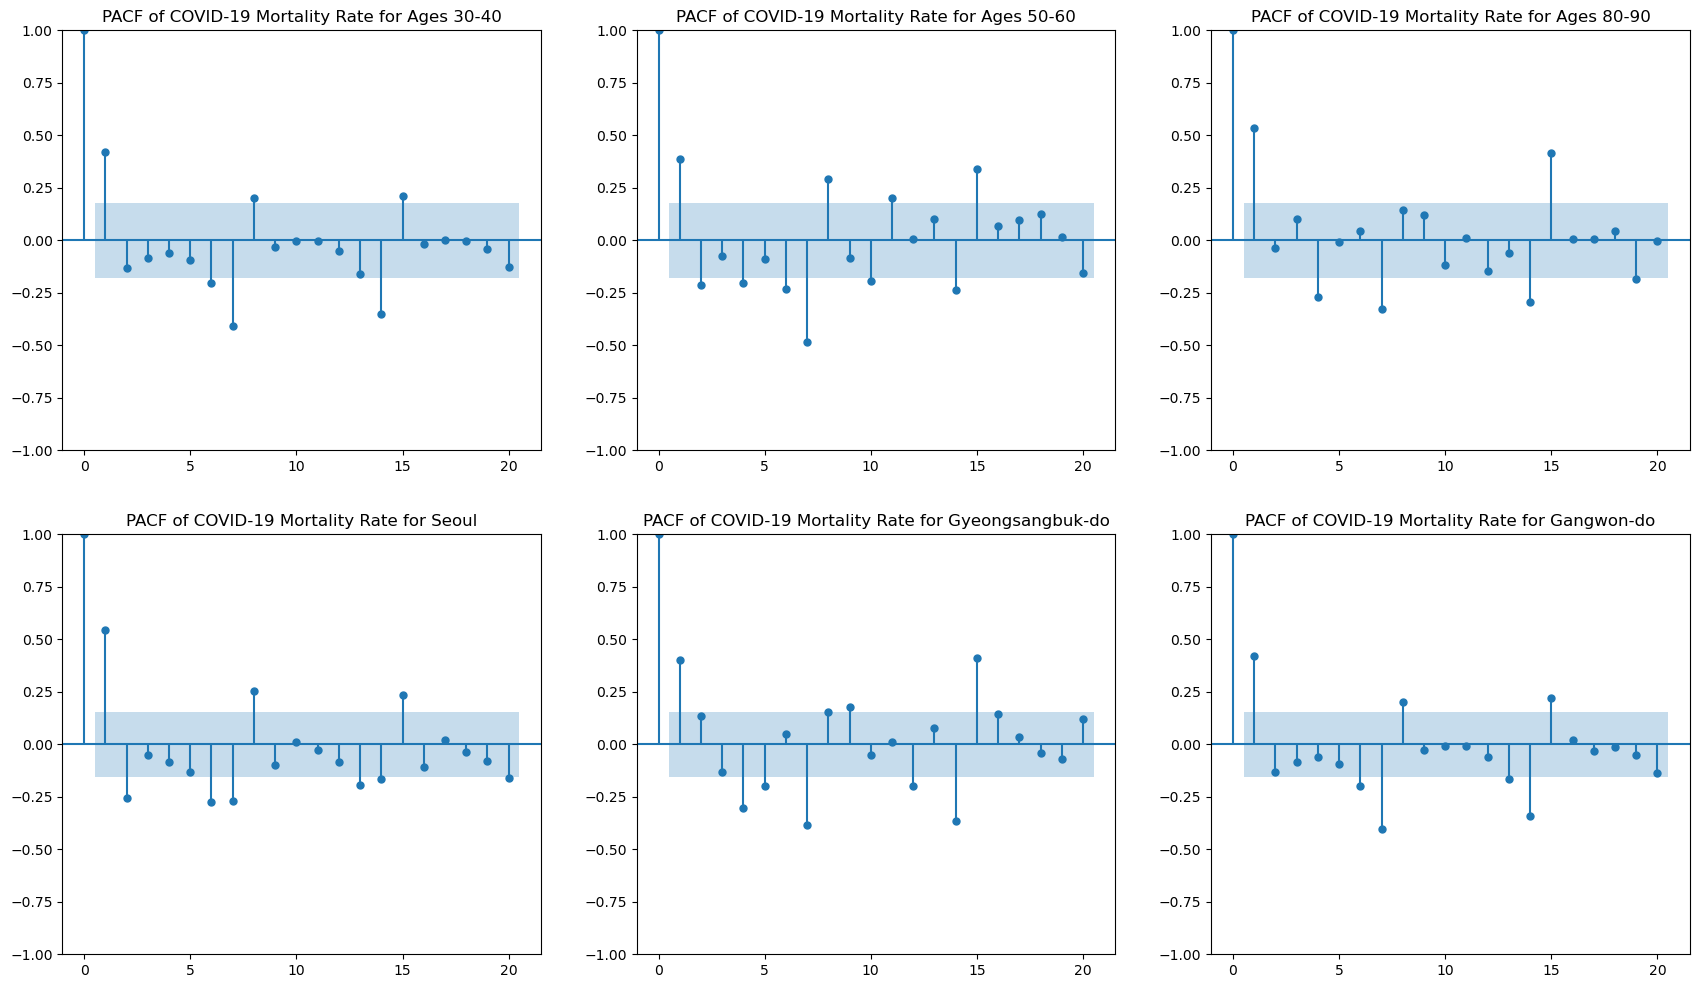

In [1500]:
# create subplot for graphing PACFs of age and province residues
fig, axs = plt.subplots(nrows = 2, ncols = 3, figsize = (21, 12))


# plot PACF of residue for age 30s
plot_pacf(age_results[0].resid, lags = 20, ax = axs[0, 0])
axs[0, 0].set_title("PACF of COVID-19 Mortality Rate for Ages 30-40", fontsize = 12)

# plot PACF of residue for age 50s
plot_pacf(age_results[1].resid, lags = 20,  ax = axs[0, 1])
axs[0, 1].set_title("PACF of COVID-19 Mortality Rate for Ages 50-60", fontsize = 12)

# plot PACF of residue for age 80s
plot_pacf(age_results[2].resid, lags = 20,  ax = axs[0, 2])
axs[0, 2].set_title("PACF of COVID-19 Mortality Rate for Ages 80-90", fontsize = 12)

# plot PACF of residue for Seoul
plot_pacf(prov_results[0].resid, lags = 20, ax = axs[1, 0])
axs[1, 0].set_title("PACF of COVID-19 Mortality Rate for Seoul", fontsize = 12)

# plot PACF of residue for Gyeongsangbuk-do
plot_pacf(prov_results[1].resid, lags = 20, ax = axs[1, 1])
axs[1, 1].set_title("PACF of COVID-19 Mortality Rate for Gyeongsangbuk-do", fontsize = 12)

# plot PACF of residue for Gangwon-do
plot_pacf(prov_results[2].resid, lags = 20, ax = axs[1, 2])
axs[1, 2].set_title("PACF of COVID-19 Mortality Rate for Gangwon-do", fontsize = 12)


fig.savefig('images/PACFs of COVID-19 Mortality Rate for Age and Province.png')

plt.show()

**Observation D:** extrapolating from the PACF plots above, the parameter p for each residue is equal to the x-coordinate of the first lag whose subsequent neighbour dips into the shaded region. Below, parameters p for all AR models of age and province residues are logged.

In [1503]:
# store parameters p of AR models for age residues [30s, 50s, 80s]
ar_age_params_p = [1, 2, 1]

# store p parameters of AR models for province residues [Seoul, Gyeongsangbuk-do, Gangwon-do]
ar_prov_params_p = [2, 1, 1]

4. Split residues of data into historical as well as future components; historical for model training and future for forecast testing

In [1506]:
# create lists of historical as well as future residues to train and make forecasts respectively
age_res_hists = []
prov_res_hists = []

age_res_futures = []
prov_res_futures = []


# collect historical and future residues
for i in range(3): # 3 target ages and provinces
    age_res_hist, age_res_future = train_test_split(age_results[i].resid, shuffle = False) # default 75:25 (train:test) split
    prov_res_hist, prov_res_future = train_test_split(prov_results[i].resid, shuffle = False)
    
    age_res_hists.append(age_res_hist)
    age_res_futures.append(age_res_future)

    prov_res_hists.append(prov_res_hist)
    prov_res_futures.append(prov_res_future)
   

5. Build baseline AR models

In [1509]:
# lists for storing AR models to forecast future residues
ar_age_models = []
ar_prov_models = []

# create, fit and store AR models for historical residues
for i in range(3):
    ar_age_model = AutoReg(age_res_hists[i], ar_age_params_p[i])
    ar_age_models.append(ar_age_model.fit())

    ar_prov_model = AutoReg(prov_res_hists[i], ar_prov_params_p[i])
    ar_prov_models.append(ar_prov_model.fit())
    

6. Build optimal ARMA models using hyperparameter grid search and k-fold cross validation

In [1512]:
def arma_model_gscv(k, p_params, q_params, data, res_hist):
    '''
    This function performs hyperparameter grid search and 
    k-fold cross validation via the rolling window method 
    on ARMA models created from time series data provided
    
    Arguments
    ---------
    k: int
        number of splits for cross validation

    p_params: list[int]
        list of p parameters for grid search

    q_params: list[int]
        list of q parameters for grid search
        
    data: pd.DataFrame
        time series dataset used for modeling and cross 
        validation

    res_hist: pandas.core.series.Series
        historical residue to train optimal ARMA model
      
    Returns
    -------
    cross validated ARMA model fitted on a historical
    residue with optimal order  
    
    '''

    # remove ARMA model fit error messages
    warnings.filterwarnings('ignore')
    
    # create time series cross validator to split data using train and test indices
    tscv = TimeSeriesSplit(n_splits = k)

    # define variables for tracking ARMA model with lowest error and optimal order
    best_score = float('inf')
    optimal_arma_order = None


    # grid search for optimal parameters p and q of ARMA model
    for p in p_params:
        for q in q_params: 
            # set current arma order and initialize list of scores
            arma_order = (p, 0, q)
            scores = []            
            
            # iterate through train and test indices created by TimeSeriesSplit 
            for train_index, test_index in tscv.split(data):
                # form train and test data for ARMA model
                train_data, test_data = data.iloc[train_index], data.iloc[test_index]

                # build ARMA model, initialize state space and fit training data
                arma_model = ARIMA(train_data, order = arma_order, enforce_stationarity = True)
                arma_model.initialize_approximate_diffuse()
                arma_model_fit = arma_model.fit()

                # make ARMA forecast on test data
                arma_forecast = arma_model_fit.forecast(steps = len(test_data))

                # score forecast based on MAE and add to scores
                score = mean_absolute_error(test_data, arma_forecast)
                scores.append(score)


        # compute average MAE in scores
        avg_score = np.mean(scores) 


        # if lowest average MAE, set as best score and update optimal ARMA parameters
        if(avg_score < best_score):
            best_score = avg_score
            optimal_arma_order = arma_order 


    # create optimal ARMA model fitted on res_hist to return
    optimal_arma_model = ARIMA(res_hist, order = optimal_arma_order)
    optimal_arma_model_fit = optimal_arma_model.fit()
    
    
    return optimal_arma_model_fit

In [1514]:
# lists for storing ARMA models
arma_age_models = []
arma_prov_models = []


# chosen parameter grids for orders p,q in ARIMA model based on sample PACFs and ACFs respectively
age_p_param_grid = [[1, 7, 14], [2, 4, 8, 15], [1, 4, 7, 15]]
age_q_param_grid = [[1, 7], [1, 7], [1]]

prov_p_param_grid = [[2, 8, 15], [1, 5, 7, 12, 15], [1, 8, 15]]
prov_q_param_grid = [[1, 7], [2, 7], [1, 7]]


# 5-fold cross validation
k_folds = 5


# create and store optimal ARMA models (**NOTE:** takes about 30 seconds to fully execute)
for i in range(3):
    arma_age_models.append(arma_model_gscv(k_folds, age_p_param_grid[i], age_q_param_grid[i], age_results[i].resid, age_res_hists[i]))
    arma_prov_models.append(arma_model_gscv(k_folds, prov_p_param_grid[i], prov_q_param_grid[i], prov_results[i].resid, prov_res_hists[i]))


<br>

<h3 style="text-align:center;">Evaluation</h3><br>

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;With the modeling complete, forecasts can be made on the future age and province residues. In this section, model performance will be gauged using graphs and the Mean Absolute Error (MAE). Choosing this error metric prevents positive and negative elements from canceling each other out when reducing the forecast error array to a single value. The final objectives are:
   - Make forecasts on the future data
   - Provide clear visualizations and interpretations of the results
   - Calculate the MAE for each forecast
   - Compare the error metrics of both models

1. Make AR and ARMA forecasts, then plot results

In [1518]:
# initilize list to store AR and ARMA forecasts
ar_age_res_forecasts = []
ar_prov_res_forecasts = []

arma_age_res_forecasts = []
arma_prov_res_forecasts = []


# generate and store forecasts
for i in range(3): 
    # AR forecast = ar_model.predict(forecast start, forecast end) 
    ar_age_res_forecasts.append(ar_age_models[i].predict(len(age_res_hists[i]), len(age_res_hists[i]) + len(age_res_futures[i]) - 1))
    ar_prov_res_forecasts.append(ar_prov_models[i].predict(len(prov_res_hists[i]), len(prov_res_hists[i]) + len(prov_res_futures[i]) - 1))

    # ARMA forecast = arma_model.forecast(len(future)) 
    arma_age_res_forecasts.append(arma_age_models[i].forecast(steps = len(age_res_futures[i])))
    arma_prov_res_forecasts.append(arma_prov_models[i].forecast(steps = len(prov_res_futures[i])))
                               

<br>Before plotting the forecast results, check the ACFs of the ARMA model residues:

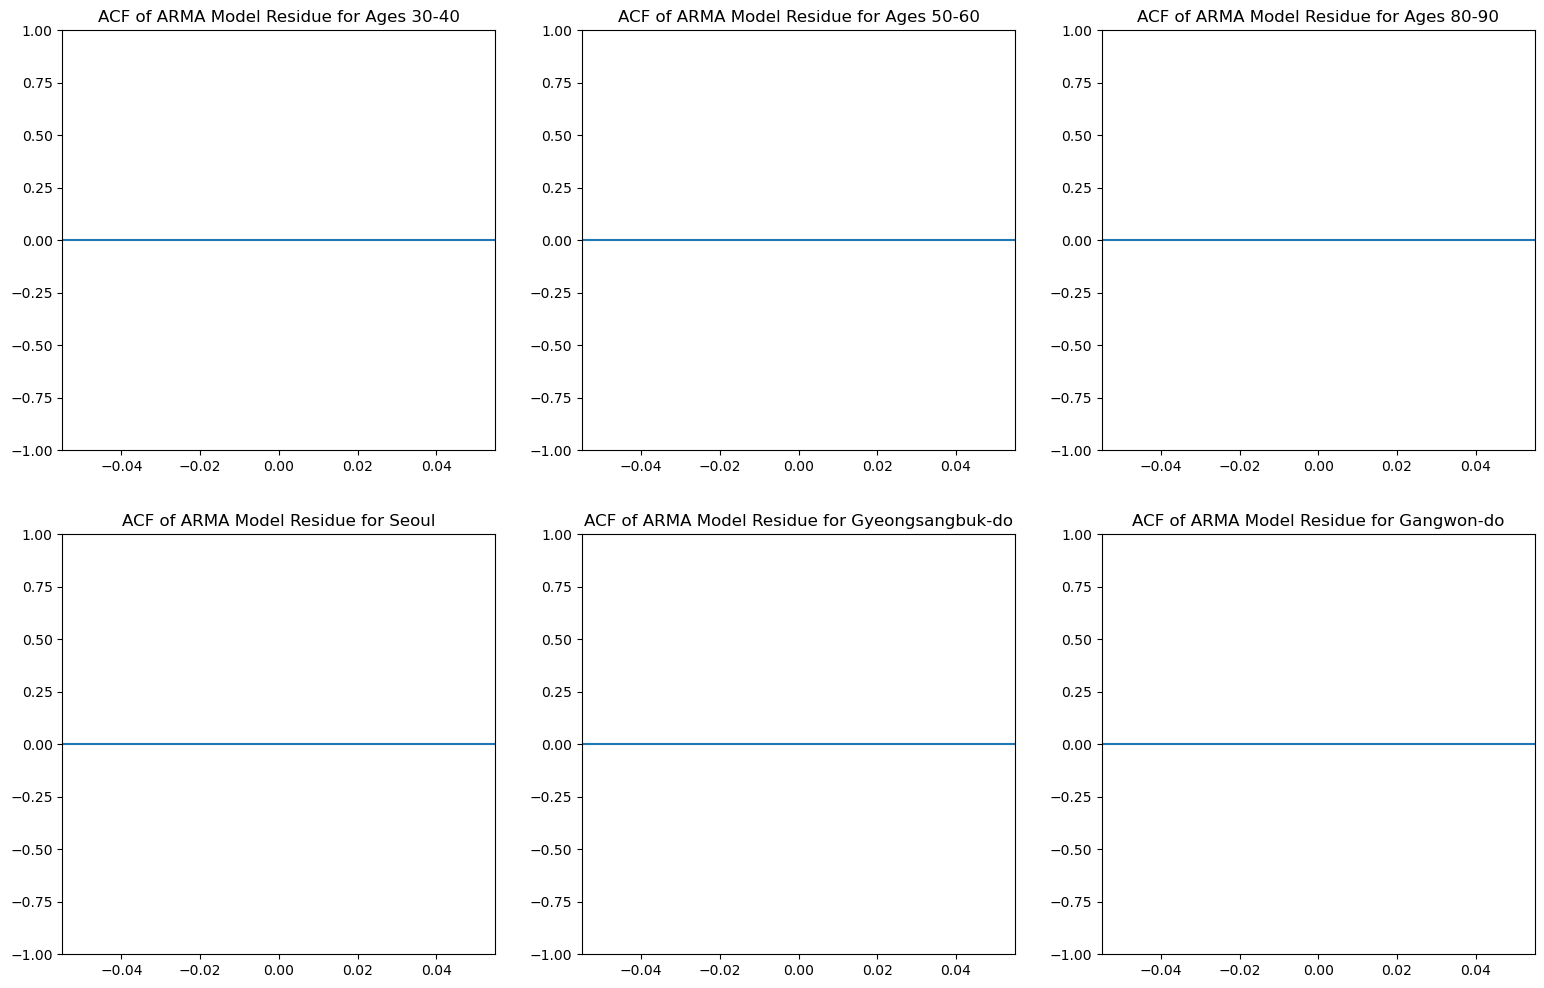

In [1521]:
# create subplot for graphing ACFs of ARMA model residues 
fig, axs = plt.subplots(nrows = 2, ncols = 3, figsize = (19, 12))


# plot ACF of ARMA model residue for age 30s
plot_acf(age_results[0].resid - arma_age_res_forecasts[0], lags = 20, ax = axs[0, 0])
axs[0, 0].set_title("ACF of ARMA Model Residue for Ages 30-40", fontsize = 12)

# plot ACF of ARMA model residue for age 50s
plot_acf(age_results[1].resid - arma_age_res_forecasts[1], lags = 20, ax = axs[0, 1])
axs[0, 1].set_title("ACF of ARMA Model Residue for Ages 50-60", fontsize = 12)

# plot ACF of ARMA model residue for age 80s
plot_acf(age_results[2].resid - arma_age_res_forecasts[2], lags = 20, ax = axs[0, 2])
axs[0, 2].set_title("ACF of ARMA Model Residue for Ages 80-90", fontsize = 12)

# plot ACF of ARMA model residue for Seoul
plot_acf(prov_results[0].resid - arma_prov_res_forecasts[0], lags = 20, ax = axs[1, 0])
axs[1, 0].set_title("ACF of ARMA Model Residue for Seoul", fontsize = 12)

# plot ACF of ARMA model residue for Gyeongsangbuk-do 
plot_acf(prov_results[1].resid - arma_prov_res_forecasts[1], lags = 20, ax = axs[1, 1])
axs[1, 1].set_title("ACF of ARMA Model Residue for Gyeongsangbuk-do", fontsize = 12)

# plot ACF of ARMA model residue for Gangwon-do
plot_acf(prov_results[2].resid - arma_prov_res_forecasts[2], lags = 20, ax = axs[1, 2])
axs[1, 2].set_title("ACF of ARMA Model Residue for Gangwon-do", fontsize = 12)


fig.savefig('images/ACFs of ARMA Model Residues for Ages and Provinces.png')

plt.show()

**Observation E:** white noise in the ACF graphs above indicates there is no more structure for the ARMA models to extract from residues of age and province data
<br><br>

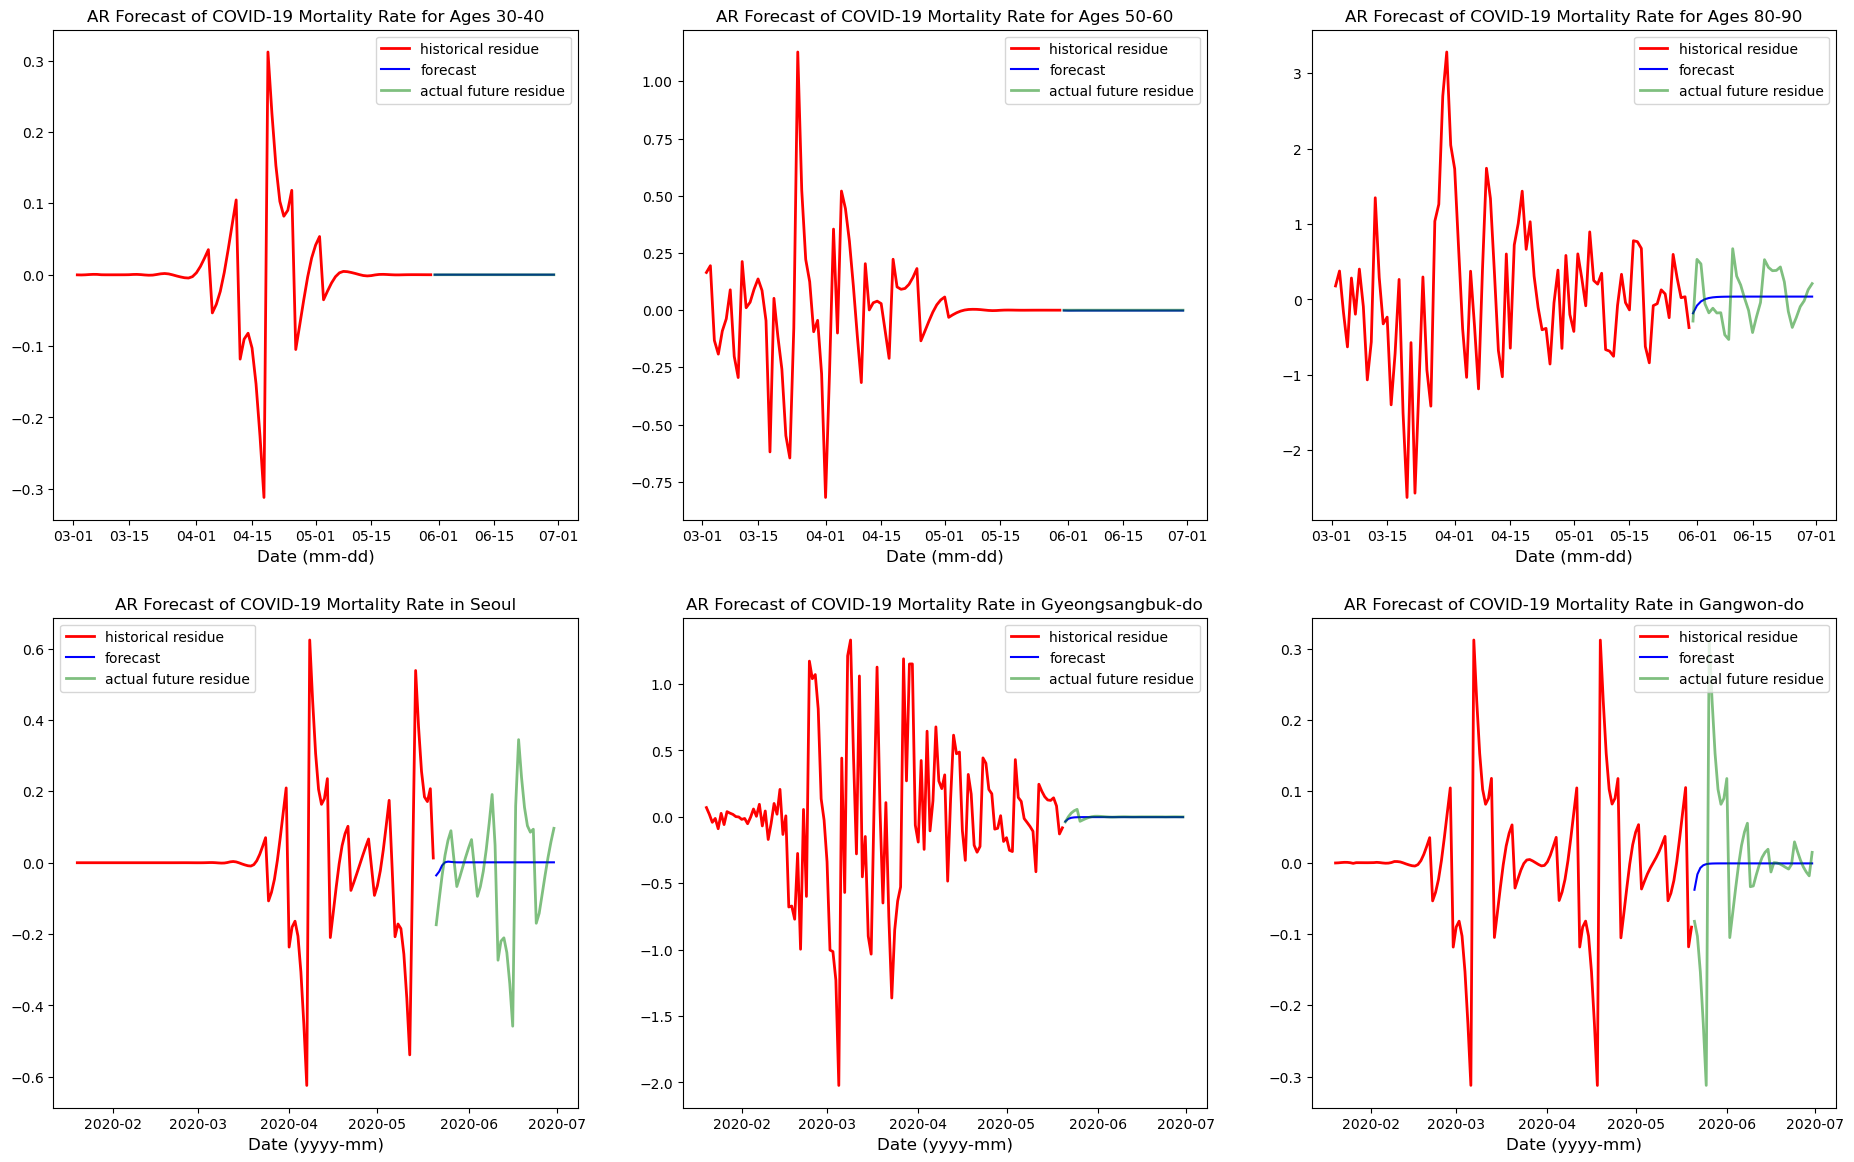

In [1524]:
# create subplot for graphing AR forecasts of age and province residues
fig, axs = plt.subplots(nrows = 2, ncols = 3, figsize = (23, 14))

xtick_labels = ['03-01', '03-15', '04-01', '04-15', '05-01', '05-15', '06-01', '06-15', '07-01']


# plot AR forecast for age 30s
axs[0, 0].plot(age_res_hists[0], label = 'historical residue', color = 'red', linewidth = 2) 
axs[0, 0].plot(ar_age_res_forecasts[0], label = 'forecast', color = 'blue')
axs[0, 0].plot(age_res_futures[0], label = 'actual future residue', alpha = 0.5, color = 'green', linewidth = 2)
axs[0, 0].set_title("AR Forecast of COVID-19 Mortality Rate for Ages 30-40", fontsize = 12)
axs[0, 0].legend()
axs[0, 0].set_xticks(axs[0, 0].get_xticks(), labels = xtick_labels)
axs[0, 0].set_xlabel("Date (mm-dd)", fontsize = 12)

# plot AR forecast for age 50s
axs[0, 1].plot(age_res_hists[1], label = 'historical residue', color = 'red', linewidth = 2) 
axs[0, 1].plot(ar_age_res_forecasts[1], label = 'forecast', color = 'blue')
axs[0, 1].plot(age_res_futures[1], label = 'actual future residue', alpha = 0.5, color = 'green', linewidth = 2)
axs[0, 1].set_title("AR Forecast of COVID-19 Mortality Rate for Ages 50-60", fontsize = 12)
axs[0, 1].legend()
axs[0, 1].set_xticks(axs[0, 1].get_xticks(), labels = xtick_labels)
axs[0, 1].set_xlabel("Date (mm-dd)", fontsize = 12)

# plot AR forecast for age 80s
axs[0, 2].plot(age_res_hists[2], label = 'historical residue', color = 'red', linewidth = 2) 
axs[0, 2].plot(ar_age_res_forecasts[2], label = 'forecast', color = 'blue')
axs[0, 2].plot(age_res_futures[2], label = 'actual future residue', alpha = 0.5, color = 'green', linewidth = 2)
axs[0, 2].set_title("AR Forecast of COVID-19 Mortality Rate for Ages 80-90", fontsize = 12)
axs[0, 2].legend()
axs[0, 2].set_xticks(axs[0, 2].get_xticks(), labels = xtick_labels)
axs[0, 2].set_xlabel("Date (mm-dd)", fontsize = 12)

# plot AR forecast for Seoul
axs[1, 0].plot(prov_res_hists[0], label = 'historical residue', color = 'red', linewidth = 2) 
axs[1, 0].plot(ar_prov_res_forecasts[0], label = 'forecast', color = 'blue')
axs[1, 0].plot(prov_res_futures[0], label = 'actual future residue', alpha = 0.5, color = 'green', linewidth = 2)
axs[1, 0].set_title("AR Forecast of COVID-19 Mortality Rate in Seoul", fontsize = 12)
axs[1, 0].legend()
axs[1, 0].set_xlabel("Date (yyyy-mm)", fontsize = 12)

# plot AR forecast for Gyeongsangbuk-do
axs[1, 1].plot(prov_res_hists[1], label = 'historical residue', color = 'red', linewidth = 2) 
axs[1, 1].plot(ar_prov_res_forecasts[1], label = 'forecast', color = 'blue')
axs[1, 1].plot(prov_res_futures[1], label = 'actual future residue', alpha = 0.5, color = 'green', linewidth = 2)
axs[1, 1].set_title("AR Forecast of COVID-19 Mortality Rate in Gyeongsangbuk-do", fontsize = 12)
axs[1, 1].legend()
axs[1, 1].set_xlabel("Date (yyyy-mm)", fontsize = 12)

# plot AR forecast for Gangwon-do
axs[1, 2].plot(prov_res_hists[2], label = 'historical residue', color = 'red', linewidth = 2) 
axs[1, 2].plot(ar_prov_res_forecasts[2], label = 'forecast', color = 'blue')
axs[1, 2].plot(prov_res_futures[2], label = 'actual future residue', alpha = 0.5, color = 'green', linewidth = 2)
axs[1, 2].set_title("AR Forecast of COVID-19 Mortality Rate in Gangwon-do", fontsize = 12)
axs[1, 2].legend()
axs[1, 2].set_xlabel("Date (yyyy-mm)", fontsize = 12)


fig.savefig('images/AR Forecasts of COVID-19 Mortality Rate for Age and Province.png')

plt.show()

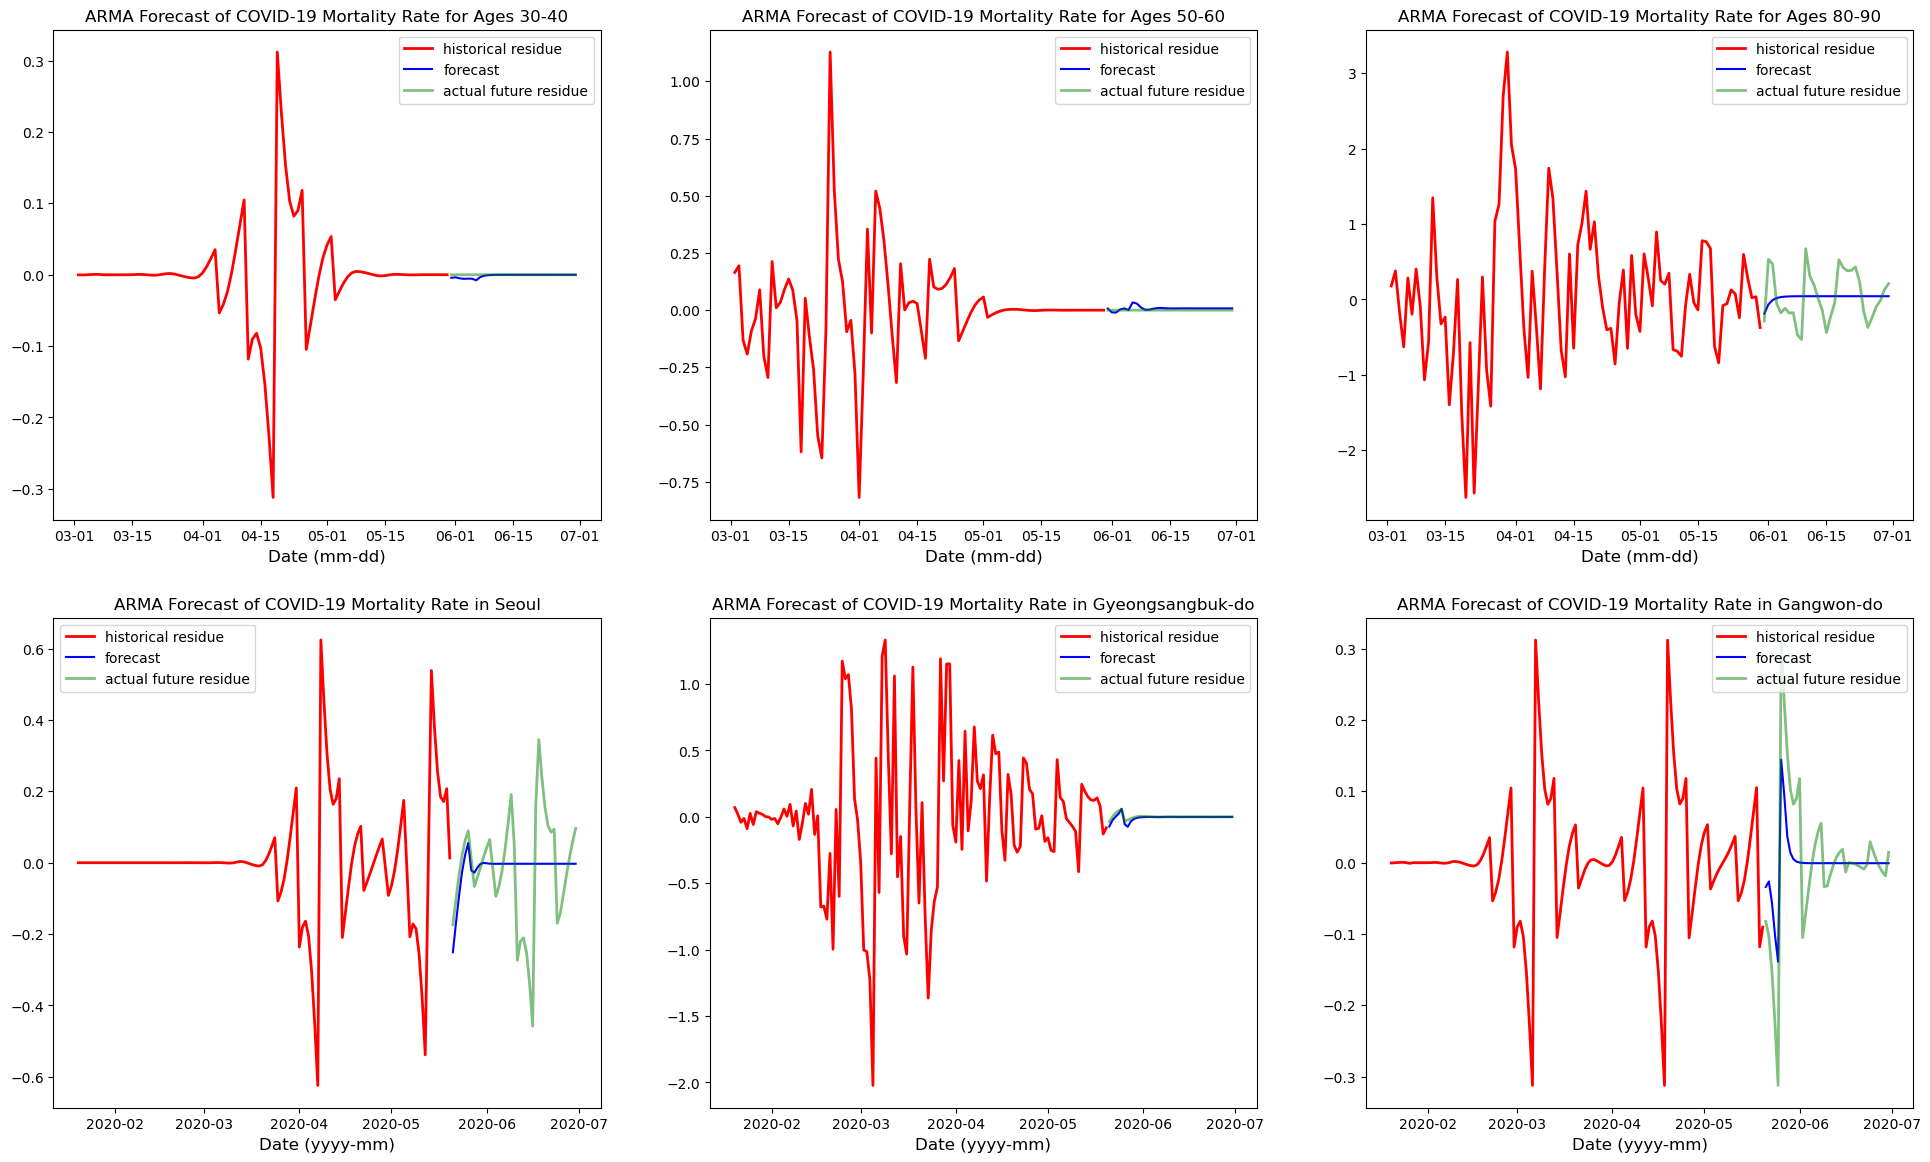

In [1526]:
# create subplot for graphing ARMA forecasts on age and province residues
fig, axs = plt.subplots(nrows = 2, ncols = 3, figsize = (24, 14))

xtick_labels = ['03-01', '03-15', '04-01', '04-15', '05-01', '05-15', '06-01', '06-15', '07-01']


# plot ARMA forecast for age 30s
axs[0, 0].plot(age_res_hists[0], label = 'historical residue', color = 'red', linewidth = 2) 
axs[0, 0].plot(arma_age_res_forecasts[0], label = 'forecast', color = 'blue')
axs[0, 0].plot(age_res_futures[0], label = 'actual future residue', alpha = 0.5, color = 'green', linewidth = 2)
axs[0, 0].set_title("ARMA Forecast of COVID-19 Mortality Rate for Ages 30-40", fontsize = 12)
axs[0, 0].legend()
axs[0, 0].set_xticks(axs[0, 0].get_xticks(), labels = xtick_labels)
axs[0, 0].set_xlabel("Date (mm-dd)", fontsize = 12)

# plot ARMA forecast for age 50s
axs[0, 1].plot(age_res_hists[1], label = 'historical residue', color = 'red', linewidth = 2) 
axs[0, 1].plot(arma_age_res_forecasts[1], label = 'forecast', color = 'blue')
axs[0, 1].plot(age_res_futures[1], label = 'actual future residue', alpha = 0.5, color = 'green', linewidth = 2)
axs[0, 1].set_title("ARMA Forecast of COVID-19 Mortality Rate for Ages 50-60", fontsize = 12)
axs[0, 1].legend()
axs[0, 1].set_xticks(axs[0, 1].get_xticks(), labels = xtick_labels)
axs[0, 1].set_xlabel("Date (mm-dd)", fontsize = 12)

# plot ARMA forecast for age 80s
axs[0, 2].plot(age_res_hists[2], label = 'historical residue', color = 'red', linewidth = 2) 
axs[0, 2].plot(arma_age_res_forecasts[2], label = 'forecast', color = 'blue')
axs[0, 2].plot(age_res_futures[2], label = 'actual future residue', alpha = 0.5, color = 'green', linewidth = 2)
axs[0, 2].set_title("ARMA Forecast of COVID-19 Mortality Rate for Ages 80-90", fontsize = 12)
axs[0, 2].legend()
axs[0, 2].set_xticks(axs[0, 2].get_xticks(), labels = xtick_labels)
axs[0, 2].set_xlabel("Date (mm-dd)", fontsize = 12)

# plot ARMA forecast for Seoul
axs[1, 0].plot(prov_res_hists[0], label = 'historical residue', color = 'red', linewidth = 2) 
axs[1, 0].plot(arma_prov_res_forecasts[0], label = 'forecast', color = 'blue')
axs[1, 0].plot(prov_res_futures[0], label = 'actual future residue', alpha = 0.5, color = 'green', linewidth = 2)
axs[1, 0].set_title("ARMA Forecast of COVID-19 Mortality Rate in Seoul", fontsize = 12)
axs[1, 0].legend()
axs[1, 0].set_xlabel("Date (yyyy-mm)", fontsize = 12)

# plot ARMA forecast for Gyeongsangbuk-do
axs[1, 1].plot(prov_res_hists[1], label = 'historical residue', color = 'red', linewidth = 2) 
axs[1, 1].plot(arma_prov_res_forecasts[1], label = 'forecast', color = 'blue')
axs[1, 1].plot(prov_res_futures[1], label = 'actual future residue', alpha = 0.5, color = 'green', linewidth = 2)
axs[1, 1].set_title("ARMA Forecast of COVID-19 Mortality Rate in Gyeongsangbuk-do", fontsize = 12)
axs[1, 1].legend()
axs[1, 1].set_xlabel("Date (yyyy-mm)", fontsize = 12)

# plot ARMA forecast for Gangwon-do
axs[1, 2].plot(prov_res_hists[2], label = 'historical residue', color = 'red', linewidth = 2) 
axs[1, 2].plot(arma_prov_res_forecasts[2], label = 'forecast', color = 'blue')
axs[1, 2].plot(prov_res_futures[2], label = 'actual future residue', alpha = 0.5, color = 'green', linewidth = 2)
axs[1, 2].set_title("ARMA Forecast of COVID-19 Mortality Rate in Gangwon-do", fontsize = 12)
axs[1, 2].legend()
axs[1, 2].set_xlabel("Date (yyyy-mm)", fontsize = 12)


fig.savefig('images/ARMA Forecasts of COVID-19 Mortality Rate for Age and Province.png')

plt.show()

2. Interpret results

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;This analysis is conducted on the model forecasts of future COVID-19 mortality rates in South Korea for patient infection case, age and province residues. These residues contain the original data stripped of seasons and trends to capture deeper underlying patterns. Essentially, evaluating the AR and ARMA models on future residues garners more robust forecasts on the mortality rate. Interpretations of the results are summarized: <br></br>
- Looking at the residues for ages 30-40 the AR forecast has near-perfect precision, whereas the ARMA variant slightly underestimates future data initially. One potential explanation for this phenomenon is the ARMA models overfitted on the training data during hyperparameter tuning. The high accuracies are most likely due to the rarity of COVID-19 deaths within this younger age group; the mortality rate does not fluctuate much.
<br>


- The situation is similar for ages 50-60 except the ARMA model over-forecasts, and at a greater magnitude. Which might be because the historical residue for these ages is relatively sporadic due to a high COVID-19 fatality rate. This demonstrates the influence of past values on the models; forecast misses still ocurr even when the trajectory of future data is linear.
<br>


- Both models perform poorly on the future residues for ages 80-90 and flatline after a few steps, suggesting that intricacies in the data remain unlearned. The forecasts also seem identical in this case; differences between model forecasts may stem from how the ARMA models were graded during cross validation. The optimal orders were selected based on the grid parameters p,q that yielded the lowest average MAE in the procedure.
<br>


- Evidently, the expected outcome of model forecasts having higher accuracy for young adults is confirmed by a significant drop in performance between the age 50s and 80s residues. Additionally, forecasts on the residues for ages 30-40 and 50-60 are consistently accurate. 
<br>


- Moving on to provinces, Seoul has by far the largest population density in South Korea, and so frequent changes in the mortality rate are anticipated. The first distinction between the AR and ARMA model is made here; while the AR forecast exhibits the same behaviour seen in the residue for ages 80-90, the ARMA forecast's form actually resembles that of early future data before subsequently flatlining. 
<br>


-  Next is Gyeongsangbuk-do which, given its large population density, has quite a convoluted historical residue that stabilizes suddenly within the forecasting period. The ARMA forecast closely adheres to the future residue despite this, but the AR model has trouble forecasting the abrubt shift.  
<br>


- Gangwon-do's small population density could explain the well-defined tendencies of its residue. That being said, both AR and ARMA models struggle to replicate them in their forecasts. With the former falling apart almost immediately and the latter achieving some success in matching the general shape of future data. 
<br>


- From the previous few points, the claim that both models have worse forecast accuracy for provinces with larger population density is not entirely true. While this assumption holds in the comparison between between Seoul and Gangwon-do, it is proven false by Gyeongsangbuk-do versus Gangwon-do, since Gyeongsangbuk-do is more population dense.
<br>


- Clearly, both models experience difficulty forecasting the underlying patterns in the age and province residues. However, the ARMA model extracts more data and outperforms the AR model in every province residue forecast (tying for ages 80-90).<br></br>

3. Calculate MAEs of AR and ARMA forecasts

In [1530]:
# list for storing MAEs of AR and ARMA forecasts
MAEs_ar_age = []
MAEs_ar_prov = []

MAEs_arma_age = []
MAEs_arma_prov = []


# calculate and store MAEs
for i in range(3):
    # calculate MAE for age and province AR forecasts
    MAE_ar_age = mean_absolute_error(age_res_futures[i], ar_age_res_forecasts[i])
    MAEs_ar_age.append(MAE_ar_age)

    MAE_ar_prov = mean_absolute_error(prov_res_futures[i], ar_prov_res_forecasts[i])
    MAEs_ar_prov.append(MAE_ar_prov)

    
    # calculate MAE for age and province ARMA forecasts
    MAE_arma_age = mean_absolute_error(age_res_futures[i], arma_age_res_forecasts[i])
    MAEs_arma_age.append(MAE_arma_age)

    MAE_arma_prov = mean_absolute_error(prov_res_futures[i], arma_prov_res_forecasts[i])
    MAEs_arma_prov.append(MAE_arma_prov)
    

4. Compare MAEs for AR and ARMA models (NOTE: 'gsbd' = Gyeongsangbuk-do, 'gwd' = Gangwon-do)

In [1533]:
# create dataframe of MAEs for AR models 
MAEs_ar = {
    'Metric': ['MAE'],
    'ar_30s': [MAEs_ar_age[0]],
    'ar_50s': [MAEs_ar_age[1]],
    'ar_80s': [MAEs_ar_age[2]],
    'ar_seoul': [MAEs_ar_prov[0]],
    'ar_gsbd': [MAEs_ar_prov[1]], 
    'ar_gwd': [MAEs_ar_prov[2]] 
}


# create dataframe of MAEs for ARMA models 
MAEs_arma = {
    'Metric': ['MAE'],
    'arma_30s': [MAEs_arma_age[0]],
    'arma_50s': [MAEs_arma_age[1]],
    'arma_80s': [MAEs_arma_age[2]],
    'arma_seoul': [MAEs_arma_prov[0]],
    'arma_gsbd': [MAEs_arma_prov[1]], 
    'arma_gwd': [MAEs_arma_prov[2]]
}


MAEs_ar_df = pd.DataFrame(MAEs_ar)
MAEs_arma_df = pd.DataFrame(MAEs_arma)


# display dataframes of MAEs for AR and ARMA models
print("\n")
display(MAEs_ar_df.set_index('Metric'))
print("\n")
display(MAEs_arma_df.set_index('Metric'))

,ar_30s,ar_50s,ar_80s,ar_seoul,ar_gsbd,ar_gwd
Metric,,,,,,
MAE,0.000007,0.001605,0.280635,0.11684,0.007361,0.060943


,arma_30s,arma_50s,arma_80s,arma_seoul,arma_gsbd,arma_gwd
Metric,,,,,,
MAE,0.001478,0.008956,0.281289,0.114274,0.006717,0.046485


<br>Finally, the MAEs for AR and ARMA models must be compared to corroborate findings. Remembering lower MAE means higher accuracy, the results of this evaluation are reproduced:
- MAEs of AR forecasts are lower than ARMA forecasts for ages 30-40 and 50-60
- MAEs of the AR and ARMA forecasts are extremely close for ages 80-90
- MAEs of ARMA forecasts are lower than AR forecasts for all provinces
<br><br>